In [2]:
from argparse import Namespace
import yaml

with open('../../data/Pretrained MoLFormer/hparams.yaml', 'r') as f:
    config = Namespace(**yaml.safe_load(f))
config

Namespace(accelerator='ddp', batch_size=64, beam_size=0, checkpoint_every=5000, clip_grad=50, config_load=None, config_save=None, d_dropout=0.2, data_path='', data_root='/dccstor/medscan7/smallmolecule/runs/ba-predictor/small-data/affinity', dataset_length=None, dataset_name='sol', debug=True, device='cuda', dropout=0.1, eval_every=1000, fast_dev_run=False, fc_h=512, finetune_path='', freeze_model=False, from_scratch=False, gen_save=None, gpus=8, grad_acc=1, log_file=None, lr=0.001, lr_end=0.00030000000000000003, lr_multiplier=8, lr_start=3e-05, max_epochs=4, max_len=202, measure_name='measure', min_len=1, mode='cls', model_arch='BERT_16GPU_Both_10percent_rotate_no_masking', model_load=None, model_save='model.pt', model_save_dir='./models_dump/', n_batch=1800, n_embd=768, n_head=12, n_jobs=1, n_last=1000, n_layer=12, n_samples=None, n_workers=8, nucleus_thresh=0.9, num_epoch=1, num_feats=32, num_nodes=1, num_seq_returned=0, num_workers=0, pretext_size=0, q_dropout=0.5, restart_path='',

In [3]:
from tokenizer.tokenizer import MolTranBertTokenizer

tokenizer = MolTranBertTokenizer('bert_vocab.txt')
tokenizer.vocab

OrderedDict([('<bos>', 0),
             ('<eos>', 1),
             ('<pad>', 2),
             ('<mask>', 3),
             ('C', 4),
             ('c', 5),
             ('(', 6),
             (')', 7),
             ('1', 8),
             ('O', 9),
             ('N', 10),
             ('2', 11),
             ('=', 12),
             ('n', 13),
             ('3', 14),
             ('[C@H]', 15),
             ('[C@@H]', 16),
             ('F', 17),
             ('S', 18),
             ('4', 19),
             ('Cl', 20),
             ('-', 21),
             ('o', 22),
             ('s', 23),
             ('[nH]', 24),
             ('#', 25),
             ('/', 26),
             ('Br', 27),
             ('[C@]', 28),
             ('[C@@]', 29),
             ('[N+]', 30),
             ('[O-]', 31),
             ('5', 32),
             ('\\', 33),
             ('.', 34),
             ('I', 35),
             ('6', 36),
             ('[S@]', 37),
             ('[S@@]', 38),
             ('P', 39)

In [5]:
from train_pubchem_light import LightningModule

ckpt = '../../data/Pretrained MoLFormer/checkpoints/N-Step-Checkpoint_3_30000.ckpt'
lm = LightningModule(config, tokenizer.vocab).load_from_checkpoint(ckpt, config=config, vocab=tokenizer.vocab)
lm

Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding


LightningModule(
  (tok_emb): Embedding(2362, 768)
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): RotateAttentionLayer(
          (inner_attention): LinearAttention(
            (feature_map): GeneralizedRandomFeatures()
          )
          (query_projection): Linear(in_features=768, out_features=768, bias=True)
          (key_projection): Linear(in_features=768, out_features=768, bias=True)
          (value_projection): Linear(in_features=768, out_features=768, bias=True)
          (out_projection): Linear(in_features=768, out_features=768, bias=True)
          (rotaryemb): RotaryEmbedding()
        )
        (linear1): Linear(in_features=768, out_features=768, bias=True)
        (linear2): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [6]:
import torch
from fast_transformers.masking import LengthMask as LM

def batch_split(data, batch_size=64):
    i = 0
    while i < len(data):
        yield data[i:min(i+batch_size, len(data))]
        i += batch_size

def embed(model, smiles, tokenizer, batch_size=64):
    model.eval()
    embeddings = []
    for batch in batch_split(smiles, batch_size=batch_size):
        batch_enc = tokenizer.batch_encode_plus(batch, padding=True, add_special_tokens=True)
        idx, mask = torch.tensor(batch_enc['input_ids']), torch.tensor(batch_enc['attention_mask'])
        with torch.no_grad():
            token_embeddings = model.blocks(model.tok_emb(idx), length_mask=LM(mask.sum(-1)))
        # average pooling over tokens
        input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        embedding = sum_embeddings / sum_mask
        embeddings.append(embedding.detach().cpu())
    return torch.cat(embeddings)

In [9]:
import pandas as pd

df = pd.read_csv('../../data/trapnell_drugs_smiles.csv')#.sample(frac=0.1)  # speed things up...
# chang the 'smile' column name to 'smiles'
df = df.rename(columns={'smile': 'smiles'})
df

,drug,smiles,other
0,2-Methoxyestradiol,COc1cc2c(cc1O)CC[C@@H]1[C@@H]2CC[C@]2(C)[C@@H]...,Angiogenesis
1,A-366,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C21CCC1,Epigenetics
2,ABT-737,CN(C)CCC(CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)c2cc...,Apoptosis
3,AC480,Cc1c(NC(=O)OCC2COCCN2)cn2ncnc(Nc3ccc4c(cnn4Cc4...,Protein Tyrosine Kinase
4,AG-14361,CN(C)Cc1ccc(-c2nc3cccc4c3n2CCNC4=O)cc1,DNA Damage
...,...,...,...
184,YM155,COCCn1c2c([n+](Cc3cnccn3)c1C)C(=O)c1ccccc1C2=O...,Apoptosis
185,ZM,COc1cc2c(Nc3ccc(NC(=O)c4ccccc4)cc3)ncnc2cc1OCC...,Cell Cycle
186,Zileuton,CC(c1cc2ccccc2s1)N(O)C(N)=O,Metabolism
187,control,CS(C)=O,NaN


In [11]:
from rdkit import Chem
from sklearn.linear_model import LogisticRegression

def canonicalize(s):
    return Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True, isomericSmiles=False)

smiles = df.smiles.apply(canonicalize)
embeddings = embed(lm, smiles, tokenizer).numpy()

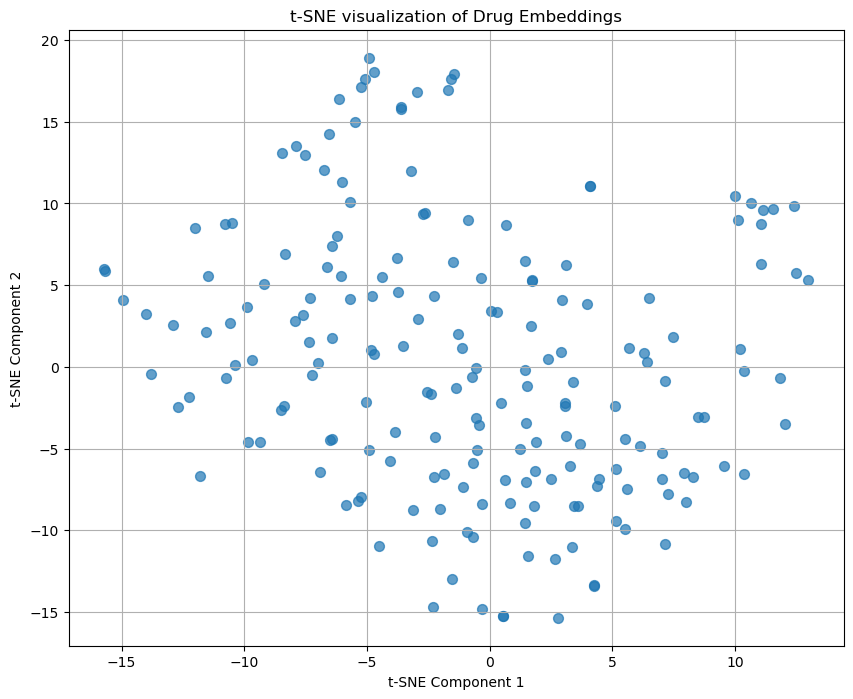

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming `embeddings` is your (189, 768) numpy array or tensor
# Example: embeddings = np.random.rand(189, 768)

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Fit and transform the embeddings
tsne_results = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, alpha=0.7)
plt.title('t-SNE visualization of Drug Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()
